In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from IPython.core.pylabtools import figsize

SAVE_FIG = True

if SAVE_FIG:
    from matplotlib import rcParams  
    rcParams['axes.labelsize'] = 9  
    rcParams['xtick.labelsize'] = 9  
    rcParams['ytick.labelsize'] = 9  
    rcParams['legend.fontsize'] = 9 
    default_fig_w = 8
    default_fig_h = 5
else:
    default_fig_w = 16
    default_fig_h = 10

%matplotlib inline
figsize(default_fig_w, default_fig_h)

# Load and adjust the data

In [2]:
df_train = pd.read_csv('../data/TableS2_training.csv', keep_default_na=False)
df_train['RRF_Measured'] = df_train['RRF_Measured'] * 1e-2
df_train['RRF_Predicted'] = df_train['RRF_Predicted'] * 1e-2

df_test = pd.read_csv('../data/TableS3_training.csv', keep_default_na=False)
df_test['RRF_Measured'] = df_test['RRF_Measured'] * 1e-2
df_test['RRF_Predicted'] = df_test['RRF_Predicted'] * 1e-2

df_val = pd.read_csv('../data/Table1_predictions.csv', keep_default_na=False)
df_val['RRF_Predicted'] = df_val['RRF_Predicted'] * 1e-2

features = ['MV', 'logD', 'abs_mob']
target = ['RRF_Measured']

df_train.head(3)

,Name,Annotation,Short Name,InChI,MH+ Fragment,MH+ Isotope,fragment/isotope,MV,logD,abs_mob,zeff,RRF_Measured,RRF_Predicted
0,L-Alanine,a,Ala,"InChI=1S/C3H7NO2/c1-2(4)3(5)6/h2H,4H2,1H3,(H,5...",90,,,70.3,-2.79,3.140000,0.764,0.000595,-0.01360
1,β-Alanine,a,β-Ala,"InChI=1S/C3H7NO2/c4-2-1-3(5)6/h1-2,4H2,(H,5,6)",90,,,70.4,-3.01,4.140000,0.995,0.000503,-0.01270
2,γ-Aminobutyric acid,a,GABA,"InChI=1S/C4H9NO2/c5-3-1-2-4(6)7/h1-3,5H2,(H,6,7)",104,,,89.2,-3.10,0.000409,1.000,0.000903,-0.00476


# Data preparation
- Exclude certain metabolites
- Select training and testing data

In [3]:
# Training Data
X_train = df_train[features]
X_train = X_train[df_train['Annotation'] == '']

y_train = df_train[target]
y_train = y_train[df_train['Annotation'] == '']

# Fit liner model on the data from Table S2

In [4]:
from sklearn import linear_model

regr = linear_model.LinearRegression()

regr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [5]:
print('New Linear Regression Model:')
print('Coefficients: {:.5f} {:.5f} {:.5f}'.format(*regr.coef_[0]))
print('Intercept: {:.5f}'.format(regr.intercept_[0]))


paper_coef = [4.40e-4, 2.7e-3, 14]
paper_intercept = -4.14e-2

print()
print('Model from paper:')
print('Coefficients: {:.5f} {:.5f} {:.5f}'.format(*paper_coef))
print('Intercept: {:.5f}'.format(paper_intercept))

New Linear Regression Model:
Coefficients: 0.00044 0.00272 14.14085
Intercept: -0.04132

Model from paper:
Coefficients: 0.00044 0.00270 14.00000
Intercept: -0.04140


# Make predictions on the training set

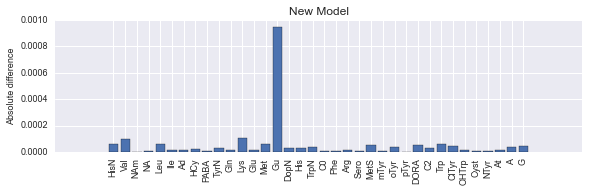

In [6]:
predictions_train = Series(np.ravel(regr.predict(X_train)), index=X_train.index, name='RRF_Predicted_New')

data_train = df_train.loc[X_train.index]

data_train = pd.concat([data_train, predictions_train], axis=1)

data_train['Diff'] = np.abs(data_train['RRF_Predicted'] - data_train['RRF_Predicted_New'])

figsize(default_fig_w, default_fig_h / 2.0)
fig, ax = plt.subplots()
xticks = np.arange(len(data_train))
plt.bar(xticks, data_train['Diff'].values, align='center')
ax.set_xticks(xticks)
ax.set_xticklabels(data_train['Short Name'].values, rotation=90)
plt.grid(True)
plt.title('New Model')
plt.ylabel('Absolute difference')
plt.tight_layout(pad=0.1)
if SAVE_FIG:
    fig.savefig('../figures/linear_model_train_diff.pdf')
plt.show()

# Make predictions on the test set

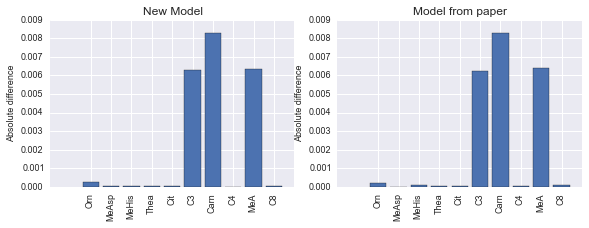

In [7]:
X_test = df_test[features]
y_test = df_test[target]

predictions_test = Series(np.ravel(regr.predict(X_test)), index=X_test.index, name='RRF_Predicted_New')

data_test = df_test.loc[X_test.index]

data_test = pd.concat([data_test, predictions_test], axis=1)

data_test['Diff'] = np.abs(data_test['RRF_Predicted'] - data_test['RRF_Predicted_New'])

paper_model = np.array([4.40e-4, 2.7e-3, 14, -4.14e-2])
predictions_test_org = Series(np.dot(paper_model, np.column_stack((X_test, np.ones(len(X_test)))).T), name='RRF_Predicted_Org')

data_test_org = df_test.loc[X_test.index]

data_test_org = pd.concat([data_test_org, predictions_test_org], axis=1)

data_test_org['Diff'] = np.abs(data_test_org['RRF_Predicted'] - data_test_org['RRF_Predicted_Org'])

# Plot
figsize(default_fig_w, default_fig_h * 0.6)
ax = plt.subplot(121)

xticks = np.arange(len(data_test))
plt.bar(xticks, data_test['Diff'].values, align='center')
ax.set_xticks(xticks)
ax.set_xticklabels(data_test['Short Name'].values, rotation=90)
plt.grid(True)
plt.title('New Model')
plt.ylabel('Absolute difference')

ax = plt.subplot(122)

xticks = np.arange(len(data_test_org))
plt.bar(xticks, data_test_org['Diff'].values, align='center')
ax.set_xticks(xticks)
ax.set_xticklabels(data_test_org['Short Name'].values, rotation=90)
plt.grid(True)
plt.title('Model from paper')
plt.ylabel('Absolute difference')

plt.tight_layout(pad=0.1)

if SAVE_FIG:
    plt.savefig('../figures/model_comparison_test_diff.pdf')

plt.show()

**Even when we use the model reported in the paper, we get results that do not match perfectly to the reported results**

# Comparison of model metrics on training set

In [8]:
y_true = data_train['RRF_Measured']
y_pred = data_train['RRF_Predicted']
y_pred_new = data_train['RRF_Predicted_New']

## Metrics of the model reported in the paper

In [9]:
print("explained_variance", explained_variance_score(y_true, y_pred))
print("mean_absolute_error", mean_absolute_error(y_true, y_pred))
print("mean_squared_error", mean_squared_error(y_true, y_pred))
print("r2_score", r2_score(y_true, y_pred))

explained_variance 0.828348380635
mean_absolute_error 0.00532638888889
mean_squared_error 4.81188027778e-05
r2_score 0.828341767487


## Metrics of our model

In [10]:
print("explained_variance", explained_variance_score(y_true, y_pred_new))
print("mean_absolute_error", mean_absolute_error(y_true, y_pred_new))
print("mean_squared_error", mean_squared_error(y_true, y_pred_new))
print("r2_score", r2_score(y_true, y_pred_new))

explained_variance 0.827874596497
mean_absolute_error 0.00535788018367
mean_squared_error 4.82497589716e-05
r2_score 0.827874596497


# Making predictions the validation set

In [11]:
X_val = df_val[features]
y_val = df_val[['RRF_Predicted']]

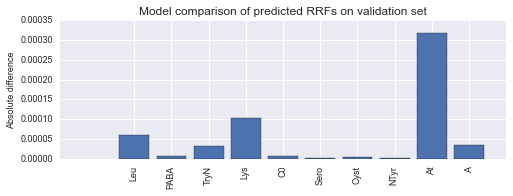

In [12]:
predictions_val = Series(np.ravel(regr.predict(X_val)), name='RRF_Predicted_New')

data_val = df_val.loc[X_val.index]

data_val = pd.concat([data_val, predictions_val], axis=1)

data_val['Diff'] = np.abs(data_val['RRF_Predicted'] - data_val['RRF_Predicted_New'])

figsize(default_fig_w, default_fig_h / 2.0)
fig, ax = plt.subplots()
xticks = np.arange(len(data_val))
plt.bar(xticks, data_val['Diff'].values, align='center')
ax.set_xticks(xticks)
ax.set_xticklabels(data_val['Short Name'].values, rotation=90)
plt.grid(True)
plt.title('Model comparison of predicted RRFs on validation set')
plt.ylabel('Absolute difference')
plt.show()